# thal1 Fourier Coefficients

Manually create XPP-compatible tables for the $\mathcal{H}$-functions

Recall from [here](https://sites.pitt.edu/~phase/bard/bardware/xpp/help/xppodes.html): that we require the format:

```
npts
xlo
xhi
y(xlo)
...
y(xhi)
```

The domain of the function is `[xlo,xhi]`

In XPP, the format to load the file is given by,

`table name filename`



# Inits

In [1]:
import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is
# user-defined
import nmCoupling as nm
# import nmCoupling_old as nm
import response as rp

import cgl1 as c1
from lib.functions import g1

from lib.util import (get_phase, freq_est, get_tongue_1d, pl_exist_1d, 
                      get_period, bif1d, follow_phase_diffs, _get_sol,
                      get_phase_diff_f_v2, get_period_all)

from generate_figures import _full_cgl1

from lib.rhs import _redu_c, _full, rhs_avg_1df
from lib.plot_util import (add_diagram_1d_scatter, quick_plot_combined,
                           add_diagram_full, add_diagram_1d,
                           load_diagram_full_f)

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sym

from scipy.optimize import root,bisect
from copy import deepcopy
import os

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

nmc = nm.nmCoupling
rsp = rp.Response

## Dicts

In [2]:
kw_sim = {'rtol':1e-9,'atol':1e-9,'method':'LSODA'}

In [3]:
kws1 = {'var_names':['x','y'],
       'init':np.array([1,0,2*np.pi]),
       'TN':2000,
       'idx':0,
       'model_name':'cglf0',
       'trunc_order':1,
       'recompute_list':[],
       'g_forward':False,
       'z_forward':False,
       'i_forward':[False,True,True,True,True,True,True],
       'i_bad_dx':[False,True,False,False,False,False,False],
       'max_iter':20,
       'rtol':1e-12,
       'atol':1e-12,
       'rel_tol':1e-9,
       'forcing_fn':[g1,lambda x:-20*g1(x+1)],
       'rhs':c1.rhs_old2}

In [4]:
pd_cgl_template = {'sig':.08,'rho':.12,'mu':1,'om':1,'om_fix':1}

In [5]:
x = np.linspace(-np.pi,np.pi,10000000)
np.mean(g1(x))

2.8199134368833257e-08

## Defs

In [6]:
data_dir = 'xpp_tables/'
if not(os.path.isdir(data_dir)):
    os.mkdir(data_dir)

In [7]:
kw_bif = {'method':'LSODA','dense_output':True,'rtol':1e-10,'atol':1e-10}

In [8]:
eps_list11r = np.linspace(0.001,.1,50)
etup11 = (.001,.1,50)

In [9]:
x_temp = np.linspace(-np.pi,3*np.pi,500)

In [10]:
def get_coeffs(a,k):
    coeffs = np.fft.fft(a.system1.h['dat'][k])
    
    # get coeffs above threshold
    threshold = 0.1
    coeffs_re_all = np.real(coeffs)
    coeffs_im_all = np.imag(coeffs)
    nn = np.arange(len(coeffs),dtype='int')
    
    coeffs_re_bool = (np.abs(coeffs_re_all) > threshold)*(nn<a.NH/2)
    coeffs_im_bool = (np.abs(coeffs_im_all) > threshold)*(nn<a.NH/2)
    
    print(coeffs_re_bool.sum(),np.where(coeffs_re_bool>0))
    print(coeffs_im_bool.sum(),np.where(coeffs_im_bool>0))
    
    print('re',coeffs_re_all[coeffs_re_bool])
    print('im',coeffs_im_all[coeffs_im_bool])
    
    freqs = np.fft.fftfreq(len(coeffs),d=(1/a.NH))
    
    coeffs_re = coeffs_re_all[coeffs_re_bool]
    coeffs_im = coeffs_im_all[coeffs_im_bool]
    
    freqs[coeffs_re_bool]

    return coeffs_re, coeffs_im, freqs[coeffs_re_bool], freqs[coeffs_im_bool]

def call_fourier_series(a,coeffs_re,coeffs_im,fr,fi):
    tot = 0
    for i,c in enumerate(coeffs_re):
        if fr[i] == 0:
            tot += c/a11.NH
        else:
            tot += 2*c*np.cos(a.x*fr[i])/a.NH
    
    for i,c in enumerate(coeffs_im):
        tot += -2*c*np.sin(a.x*fi[i])/a.NH

    return tot

def print_fourier_series(a,coeffs_re,coeffs_im,fr,fi):
    # display copy/paste-able equation
    eq = ''
    for i,c in enumerate(coeffs_re):
        if fr[i] == 0:
            eq += '{:.4f}'.format(c/a11.NH)
        else:
            eq += '+2*cos(x*{})*({:.4f})'.format(fr[i],c/a.NH)
    
    for i,c in enumerate(coeffs_im):
        eq += '-2*sin(x*{})*({:.4f})'.format(fi[i],c/a.NH)
        #tot += -2*c*np.sin(x*freqs[coeffs_re_bool][i])/a11.NH
    return eq


## Initialize Response Functions

In [11]:
system1 = rsp(**{'pardict':pd_cgl_template,**kws1})

mkdir ./data/cglf0/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0000000000003393
* Loading monodromy...
* Floquet Exponent kappa =-0.15999999999969344
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...


# 1:1

In [12]:
#recompute_list = ['h_data_cglf0','h_data_cglf0','p_data_cglf0','p_data_cglf0']
recompute_list = []
kw_nm11 = {'system1':system1,'system2':None,'_n':('om0',1),'_m':('om1',1),
         'NH':300,'save_fig':False,'recompute_list':recompute_list}

In [13]:
del11_p01 = 0.01
a11 = nm.nmCoupling(**kw_nm11, del1=del11_p01)

u expr eps**2*f2 + eps*f1
tmp eps**3*f2*i_cglf0_x0[1]*p_cglf0[1] + eps**2*(f1*i_cglf0_x0[1]*p_cglf0[1] + f2*i_cglf0_x0[0]) + eps*f1*i_cglf0_x0[0]
p sym k 0
p sym k f_imp1(th1)*ix0_0(th0)
h sym 0 f_imp1(th1)*zx0_0(th0)
h sym 1 f_imp1(th1)*zx0_1(th0)*p_cglf0[1] + f_imp2(th1)*zx0_0(th0)
* Loading p...
p order=0
* Computing H cglf0, order=0...
p order=1
system1 p f_imp1(th1)*ix0_0(th0) k= 1
* Computing H cglf0, order=1...


Might need to stick with Fourier coefficients. At least for CGL. Much simpler this way.

Recall: Given the fourier coefficients $c_n$ for $n \in\mathbb{Z}$ and supposing that $c_n = a_n + i b_n$, the real Fourier series is given by,
$$\sum_{n =1}^\infty 2 a_n \cos(n \omega t) - 2 b_n \sin(n \omega t).$$
So I really only need to save the coefficients for positive frequencies and double them. 

Goal: given a function, display a list of coefficients (maybe implement text output to copy/past into XPP)

## eps coeffs

In [14]:
coeffs_re, coeffs_im, fr, fi = get_coeffs(a11,0)

1 (array([1]),)
1 (array([1]),)
re [-49.4315203]
im [-32.95434635]


In [15]:
tot = call_fourier_series(a11,coeffs_re,coeffs_im,fr,fi)
print(print_fourier_series(a11,coeffs_re,coeffs_im,fr,fi))

+2*cos(x*1.0)*(-0.1648)-2*sin(x*1.0)*(-0.1098)


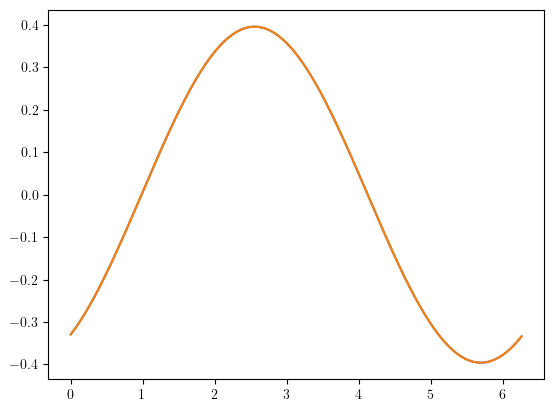

In [16]:
fig,axs = plt.subplots()
axs.plot(a11.x,tot)
axs.plot(a11.x,a11.system1.h['dat'][0])

## eps^2 coeffs

In [17]:
coeffs_re, coeffs_im, fr, fi = get_coeffs(a11,1)

2 (array([0, 1]),)
2 (array([1, 2]),)
re [   8.15252268 1088.76181366]
im [-475.79761492  -73.8929465 ]


In [18]:
tot = call_fourier_series(a11,coeffs_re,coeffs_im,fr,fi)
print(print_fourier_series(a11,coeffs_re,coeffs_im,fr,fi))

0.0272+2*cos(x*1.0)*(3.6292)-2*sin(x*1.0)*(-1.5860)-2*sin(x*2.0)*(-0.2463)


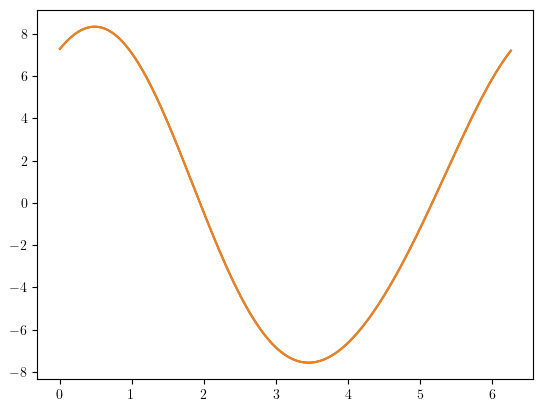

In [19]:
fig,axs = plt.subplots()
axs.plot(a11.x,tot)
axs.plot(a11.x,a11.system1.h['dat'][1])

## eps^3 coeffs

In [20]:
# coeffs_re, coeffs_im, fr, fi = get_coeffs(a11,2)

In [21]:
# tot = call_fourier_series(a11,coeffs_re,coeffs_im,fr,fi)
# print(print_fourier_series(a11,coeffs_re,coeffs_im,fr,fi))

In [22]:
# fig,axs = plt.subplots()
# axs.plot(a11.x,tot)
# axs.plot(a11.x,a11.system1.h['dat'][2])

## Save data

In [23]:
# xlo = a11.x[0]
# xhi = a11.x[-1]
# npts = len(a11.x)
# fname = 'xtab{}{}o{}.dat'

# if not(os.path.isdir(data_dir)):
#     os.mkdir(data_dir)

# for k in range(a11.system1.miter):
#     d = a11.system1.h['dat'][k]
#     d = np.insert(d,0,xhi)
#     d = np.insert(d,0,xlo)
#     d = np.insert(d,0,npts)
#     np.savetxt((data_dir+fname).format(a11._n[1],a11._m[1],k),d,
#               fmt='%.18f')

# 2:1

In [24]:
#recompute_list = ['h_data_cglf0','h_data_cglf0','p_data_cglf0','p_data_cglf0']
recompute_list = []
kw_nm21 = {'system1':system1,'system2':None,'_n':('om0',2),'_m':('om1',1),
         'NH':300,'save_fig':False,'recompute_list':recompute_list}

In [25]:
del21_p01 = 0.01
a21 = nm.nmCoupling(**kw_nm21, del1=del21_p01)

u expr eps**2*f2 + eps*f1
tmp eps**3*f2*i_cglf0_x0[1]*p_cglf0[1] + eps**2*(f1*i_cglf0_x0[1]*p_cglf0[1] + f2*i_cglf0_x0[0]) + eps*f1*i_cglf0_x0[0]
p sym k 0
p sym k f_imp1(th1)*ix0_0(th0)
h sym 0 f_imp1(th1)*zx0_0(th0)
h sym 1 f_imp1(th1)*zx0_1(th0)*p_cglf0[1] + f_imp2(th1)*zx0_0(th0)
* Loading p...
p order=0
* Computing H cglf0, order=0...
p order=1
system1 p f_imp1(th1)*ix0_0(th0) k= 1
* Computing H cglf0, order=1...


## eps coeffs

In [26]:
coeffs_re, coeffs_im, fr, fi = get_coeffs(a21,0)

1 (array([2]),)
1 (array([2]),)
re [-23.34979684]
im [-15.56653099]


In [27]:
tot = call_fourier_series(a21,coeffs_re,coeffs_im,fr,fi)
print(print_fourier_series(a21,coeffs_re,coeffs_im,fr,fi))

+2*cos(x*2.0)*(-0.0778)-2*sin(x*2.0)*(-0.0519)


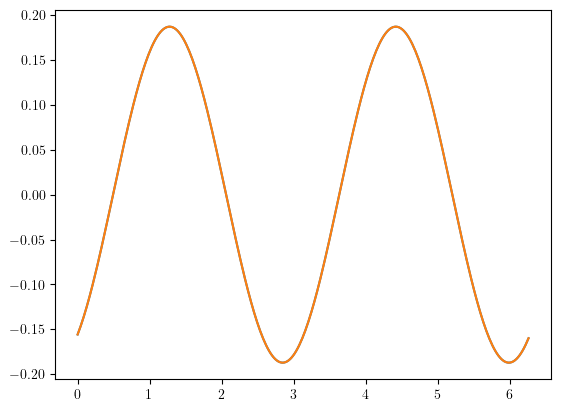

In [28]:
fig,axs = plt.subplots()
axs.plot(a21.x,tot)
axs.plot(a21.x,a21.system1.h['dat'][0])

## eps^2 coeffs

In [29]:
coeffs_re, coeffs_im, fr, fi = get_coeffs(a21,1)

2 (array([0, 2]),)
2 (array([2, 4]),)
re [31.57379796 88.7532496 ]
im [-554.19745622  -17.03236918]


In [30]:
tot = call_fourier_series(a21,coeffs_re,coeffs_im,fr,fi)
print(print_fourier_series(a21,coeffs_re,coeffs_im,fr,fi))

0.1052+2*cos(x*2.0)*(0.2958)-2*sin(x*2.0)*(-1.8473)-2*sin(x*4.0)*(-0.0568)


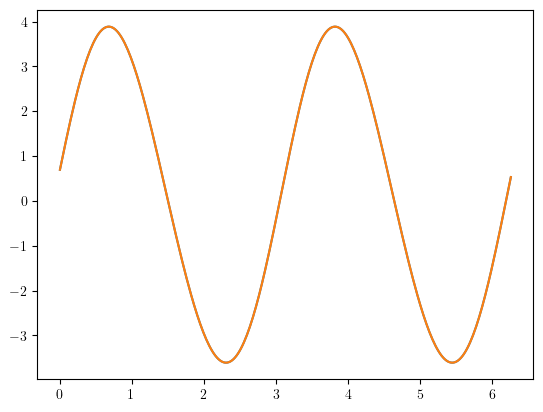

In [31]:
fig,axs = plt.subplots()
axs.plot(a21.x,tot)
axs.plot(a21.x,a21.system1.h['dat'][1])

## eps^3 coeffs

In [32]:
# coeffs_re, coeffs_im, fr, fi = get_coeffs(a21,2)

In [33]:
# tot = call_fourier_series(a21,coeffs_re,coeffs_im,fr,fi)
# print(print_fourier_series(a21,coeffs_re,coeffs_im,fr,fi))

In [34]:
# fig,axs = plt.subplots()
# axs.plot(a21.x,tot)
# axs.plot(a21.x,a21.system1.h['dat'][2])

## Save data

In [34]:
# xlo = a21.x[0]
# xhi = a21.x[-1]
# npts = len(a21.x)
# fname = 'xtab{}{}o{}.dat'

# if not(os.path.isdir(data_dir)):
#     os.mkdir(data_dir)

# for k in range(a21.system1.miter):
#     d = a21.system1.h['dat'][k]
#     d = np.insert(d,0,xhi)
#     d = np.insert(d,0,xlo)
#     d = np.insert(d,0,npts)
#     np.savetxt((data_dir+fname).format(a21._n[1],a21._m[1],k),d,
#               fmt='%.18f')

# 3:1

In [35]:
#recompute_list = ['h_data_cglf0','h_data_cglf0','p_data_cglf0','p_data_cglf0']
recompute_list = []
kw_nm31 = {'system1':system1,'system2':None,'_n':('om0',3),'_m':('om1',1),
         'NH':300,'save_fig':False,'recompute_list':recompute_list}

In [36]:
del31_p001 = 0.001
a31 = nm.nmCoupling(**kw_nm31, del1=del31_p001)

u expr eps**2*f2 + eps*f1
tmp eps**3*f2*i_cglf0_x0[1]*p_cglf0[1] + eps**2*(f1*i_cglf0_x0[1]*p_cglf0[1] + f2*i_cglf0_x0[0]) + eps*f1*i_cglf0_x0[0]
p sym k 0
p sym k f_imp1(th1)*ix0_0(th0)
h sym 0 f_imp1(th1)*zx0_0(th0)
h sym 1 f_imp1(th1)*zx0_1(th0)*p_cglf0[1] + f_imp2(th1)*zx0_0(th0)
* Loading p...
* Loading H cglf0, order=0...
* Loading H cglf0, order=1...


## eps coeffs

In [37]:
coeffs_re, coeffs_im, fr, fi = get_coeffs(a31,0)

1 (array([3]),)
1 (array([3]),)
re [-6.6898288]
im [-4.4598858]


In [38]:
tot = call_fourier_series(a31,coeffs_re,coeffs_im,fr,fi)
print(print_fourier_series(a31,coeffs_re,coeffs_im,fr,fi))

+2*cos(x*3.0)*(-0.0223)-2*sin(x*3.0)*(-0.0149)


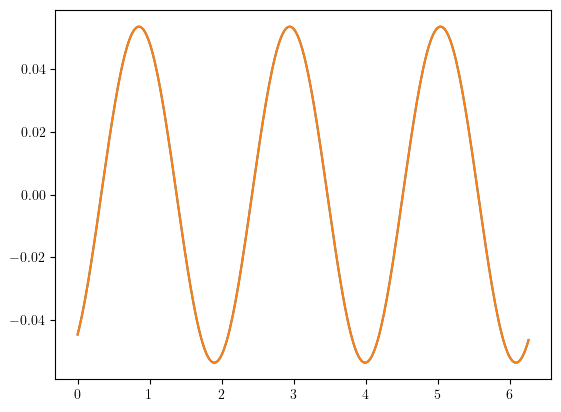

In [39]:
fig,axs = plt.subplots()
axs.plot(a31.x,tot)
axs.plot(a31.x,a31.system1.h['dat'][0])

## eps^2 coeffs

In [40]:
coeffs_re, coeffs_im, fr, fi = get_coeffs(a31,1)

2 (array([0, 3]),)
2 (array([3, 6]),)
re [  23.62929398 -119.87002394]
im [-107.1864434    -1.40200727]


In [41]:
tot = call_fourier_series(a31,coeffs_re,coeffs_im,fr,fi)
print(print_fourier_series(a31,coeffs_re,coeffs_im,fr,fi))

0.0788+2*cos(x*3.0)*(-0.3996)-2*sin(x*3.0)*(-0.3573)-2*sin(x*6.0)*(-0.0047)


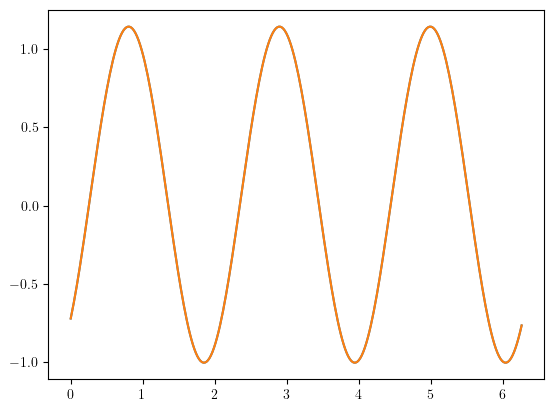

In [42]:
fig,axs = plt.subplots()
axs.plot(a31.x,tot)
axs.plot(a31.x,a31.system1.h['dat'][1])

## eps^3 coeffs

In [43]:
# coeffs_re, coeffs_im, fr, fi = get_coeffs(a31,2)

In [44]:
# tot = call_fourier_series(a31,coeffs_re,coeffs_im,fr,fi)
# print(print_fourier_series(a31,coeffs_re,coeffs_im,fr,fi))

In [45]:
# fig,axs = plt.subplots()
# axs.plot(a31.x,tot)
# axs.plot(a31.x,a31.system1.h['dat'][2])

## Save data

In [46]:
# xlo = a31.x[0]
# xhi = a31.x[-1]
# npts = len(a31.x)
# fname = 'xtab{}{}o{}.dat'

# if not(os.path.isdir(data_dir)):
#     os.mkdir(data_dir)

# for k in range(a31.system1.miter):
#     d = a31.system1.h['dat'][k]
#     d = np.insert(d,0,xhi)
#     d = np.insert(d,0,xlo)
#     d = np.insert(d,0,npts)
#     np.savetxt((data_dir+fname).format(a31._n[1],a31._m[1],k),d,
#               fmt='%.18f')

# 4:1

In [48]:
#recompute_list = ['h_data_cglf0','h_data_cglf0','p_data_cglf0','p_data_cglf0']
recompute_list = []
kw_nm41 = {'system1':system1,'system2':None,'_n':('om0',4),'_m':('om1',1),
         'NH':300,'save_fig':False,'recompute_list':recompute_list}

In [49]:
del41_p002 = 0.0001
a41 = nm.nmCoupling(**kw_nm41, del1=del41_p002)

u expr eps**2*f2 + eps*f1
tmp eps**3*f2*i_cglf0_x0[1]*p_cglf0[1] + eps**2*(f1*i_cglf0_x0[1]*p_cglf0[1] + f2*i_cglf0_x0[0]) + eps*f1*i_cglf0_x0[0]
p sym k 0
p sym k f_imp1(th1)*ix0_0(th0)
h sym 0 f_imp1(th1)*zx0_0(th0)
h sym 1 f_imp1(th1)*zx0_1(th0)*p_cglf0[1] + f_imp2(th1)*zx0_0(th0)
* Loading p...
p order=0
* Computing H cglf0, order=0...
p order=1
system1 p f_imp1(th1)*ix0_0(th0) k= 1
* Computing H cglf0, order=1...


## eps coeffs

In [50]:
coeffs_re, coeffs_im, fr, fi = get_coeffs(a41,0)

1 (array([4]),)
1 (array([4]),)
re [-1.16251793]
im [-0.77501194]


In [51]:
tot = call_fourier_series(a41,coeffs_re,coeffs_im,fr,fi)
print(print_fourier_series(a41,coeffs_re,coeffs_im,fr,fi))

+2*cos(x*4.0)*(-0.0039)-2*sin(x*4.0)*(-0.0026)


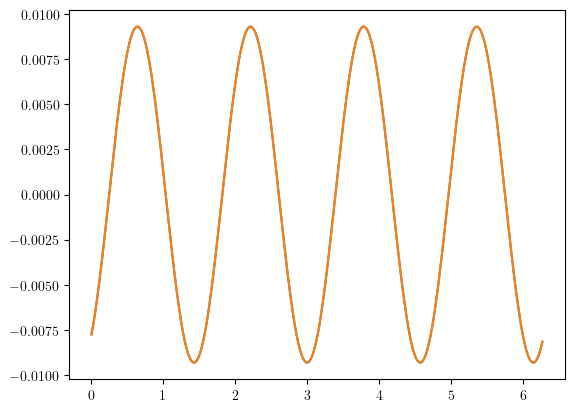

In [52]:
fig,axs = plt.subplots()
axs.plot(a41.x,tot)
axs.plot(a41.x,a41.system1.h['dat'][0])

## eps^2 coeffs

In [53]:
coeffs_re, coeffs_im, fr, fi = get_coeffs(a41,1)

2 (array([0, 4]),)
1 (array([4]),)
re [ 16.32212852 -26.92806804]
im [7.46429719]


In [54]:
tot = call_fourier_series(a41,coeffs_re,coeffs_im,fr,fi)
print(print_fourier_series(a41,coeffs_re,coeffs_im,fr,fi))

0.0544+2*cos(x*4.0)*(-0.0898)-2*sin(x*4.0)*(0.0249)


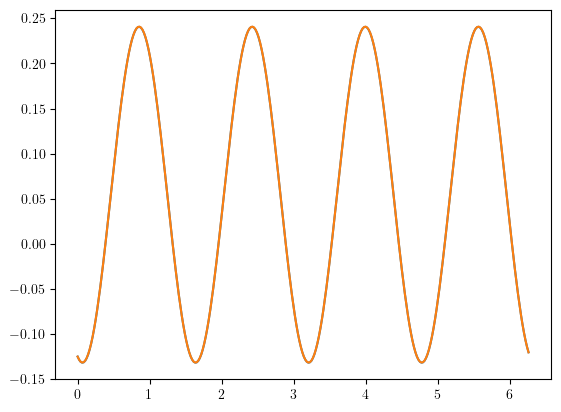

In [55]:
fig,axs = plt.subplots()
axs.plot(a41.x,tot)
axs.plot(a41.x,a41.system1.h['dat'][1])

## eps^3 coeffs

In [56]:
# coeffs_re, coeffs_im, fr, fi = get_coeffs(a41,2)

In [57]:
# tot = call_fourier_series(a41,coeffs_re,coeffs_im,fr,fi)
# print(print_fourier_series(a41,coeffs_re,coeffs_im,fr,fi))

In [58]:
# fig,axs = plt.subplots()
# axs.plot(a41.x,tot)
# axs.plot(a41.x,a41.system1.h['dat'][2])

## Save data

In [59]:
# xlo = a41.x[0]
# xhi = a41.x[-1]
# npts = len(a41.x)
# fname = 'xtab{}{}o{}.dat'

# if not(os.path.isdir(data_dir)):
#     os.mkdir(data_dir)

# for k in range(a41.system1.miter):
#     d = a41.system1.h['dat'][k]
#     d = np.insert(d,0,xhi)
#     d = np.insert(d,0,xlo)
#     d = np.insert(d,0,npts)
#     np.savetxt((data_dir+fname).format(a41._n[1],a41._m[1],k),d,
#               fmt='%.18f')